 # SAE Evaluation & Feature Analysis

 **Phase 2A:** Evaluation — Did training work?
 **Phase 2B:** Feature Analysis — What did it learn?
 **Phase 2C:** Steering Capability — Can we control generation?

 # SAE Evaluation & Feature Analysis

 **Phase 2A:** Evaluation — Did training work?
 **Phase 2B:** Feature Analysis — What did it learn?
 **Phase 2C:** Steering Capability — Can we control generation?

In [2]:
import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

try:
    # If running as regular .py script, __file__ is defined
    PROJECT_ROOT = Path(__file__).resolve().parent.parent
except NameError:
    PROJECT_ROOT = Path.cwd()
    if PROJECT_ROOT.name == "notebooks":
        PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT / "src"))

from drums_SAE.sae.model import AudioSae
from drums_SAE.training.data import LatentDataset

sns.set_theme(style="whitegrid")
Path("plots").mkdir(exist_ok=True)


@dataclass
class Config:
    checkpoint_path: str = str(PROJECT_ROOT / "checkpoints/sae_step_50000.pt")
    data_path: str = str(PROJECT_ROOT / "data/drums_encoded.npz")
    metadata_path: str = str(PROJECT_ROOT / "data/drums_encoded_metadata.csv")
    n_timesteps: int = 32  # Latent vectors per audio file
    label_columns: tuple = (
        "brightness",
        "boominess",
        "warmth",
        "hardness",
        "depth",
        "roughness",
        "sharpness",
        "loudness",
        "reverb",
    )


config = Config()
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {DEVICE}")

Device: mps


In [3]:
def load_checkpoint(path: str, device: str) -> tuple[AudioSae, dict]:
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    cfg = checkpoint["config"]
    model = AudioSae(
        d_input=cfg["d_input"],
        expansion_factor=cfg["expansion_factor"],
        topk=cfg["topk"],
        topk_aux=cfg["topk_aux"],
        dead_threshold=cfg["dead_threshold"],
    ).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, cfg


model, train_cfg = load_checkpoint(config.checkpoint_path, DEVICE)
dataset = LatentDataset(config.data_path, normalize=True)
metadata = pd.read_csv(config.metadata_path)

print(f"Model: {model.d_input}→{model.d_hidden} (TopK={model.topk})")
print(f"Dataset: {len(dataset):,} latent vectors")
print(f"Audio samples: {len(dataset) // config.n_timesteps:,}")

Loaded 328,128 latent vecs from /Users/omarhammami/hambaLab/Output/drums_SAE/data/drums_encoded.npz
Model: 64→1024 (TopK=64)
Dataset: 328,128 latent vectors
Audio samples: 10,254


In [4]:
@torch.no_grad()
def collect_outputs(model, dataset, device, batch_size=1024):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    x_all, x_hat_all, h_all, f_all = [], [], [], []

    for batch in tqdm(loader, desc="Forward pass"):
        out = model(batch.to(device), return_aux=False)
        x_all.append(batch)
        x_hat_all.append(out["x_hat"].cpu())
        h_all.append(out["h"].cpu())
        f_all.append(out["f"].cpu())

    return {
        "x": torch.cat(x_all),
        "x_hat": torch.cat(x_hat_all),
        "h": torch.cat(h_all),
        "f": torch.cat(f_all),
    }


out = collect_outputs(model, dataset, DEVICE)
x, x_hat, h, f = out["x"], out["x_hat"], out["h"], out["f"]

Forward pass:   0%|          | 0/321 [00:00<?, ?it/s]

 ## Phase 2A: Evaluation Metrics

In [5]:
explained_var = 1 - (x - x_hat).pow(2).sum(dim=-1) / (
    (x - x.mean(dim=-1, keepdim=True)).pow(2).sum(dim=-1) + 1e-8
)
mse = (x - x_hat).pow(2).mean(dim=-1)
l0 = (h > 0).float().sum(dim=-1)
feature_usage = (h > 0).float().sum(dim=0)
dead_mask = model.steps_since_fired.cpu() > model.dead_threshold

print("=" * 60)
print("PHASE 2A: EVALUATION")
print("=" * 60)
print(f"\nReconstruction:  R² = {explained_var.mean():.4f} ± {explained_var.std():.4f}")
print(f"                 MSE = {mse.mean():.6f}")
print(f"Sparsity:        L0 = {l0.mean():.1f} (target: {model.topk})")
print(f"                 {(l0 == model.topk).float().mean():.1%} exact")
print(
    f"Features:        {dead_mask.sum()}/{model.d_hidden} dead ({dead_mask.float().mean():.1%})"
)

PHASE 2A: EVALUATION

Reconstruction:  R² = 0.9873 ± 0.0176
                 MSE = 0.013867
Sparsity:        L0 = 63.9 (target: 64)
                 94.4% exact
Features:        3/1024 dead (0.3%)


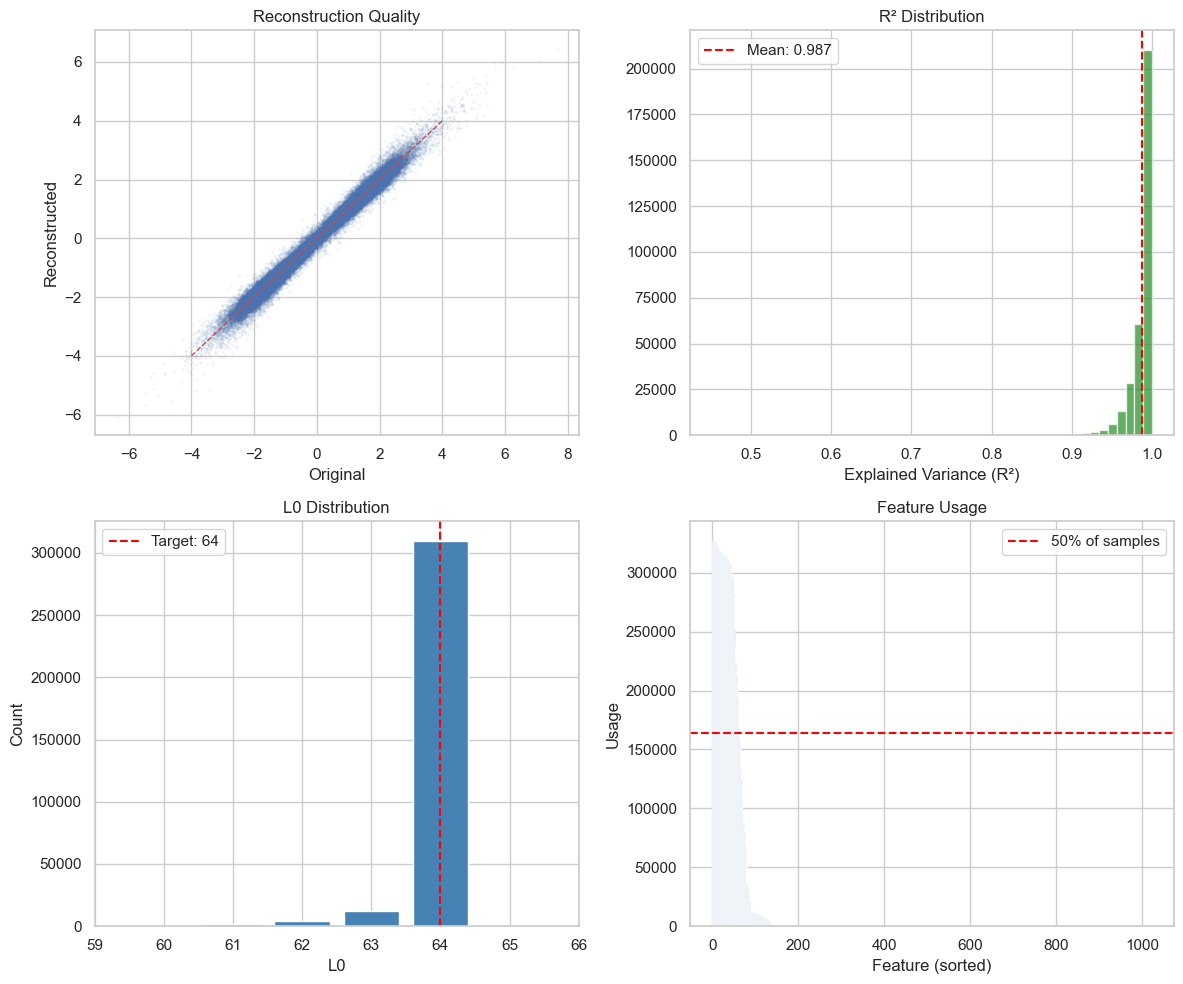

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Reconstruction scatter
ax = axes[0, 0]
idx = np.random.choice(len(x), 5000, replace=False)
ax.scatter(x[idx].flatten(), x_hat[idx].flatten(), alpha=0.05, s=1)
ax.plot([-4, 4], [-4, 4], "r--", lw=1)
ax.set(xlabel="Original", ylabel="Reconstructed", title="Reconstruction Quality")

# R² distribution
ax = axes[0, 1]
ax.hist(explained_var.numpy(), bins=50, alpha=0.7, color="forestgreen")
ax.axvline(
    explained_var.mean(),
    color="red",
    ls="--",
    label=f"Mean: {explained_var.mean():.3f}",
)
ax.set(xlabel="Explained Variance (R²)", title="R² Distribution")
ax.legend()

# L0 distribution
ax = axes[1, 0]
l0_vals, l0_counts = np.unique(l0.numpy(), return_counts=True)
ax.bar(l0_vals, l0_counts, color="steelblue")
ax.axvline(model.topk, color="red", ls="--", label=f"Target: {model.topk}")
ax.set(
    xlabel="L0",
    ylabel="Count",
    title="L0 Distribution",
    xlim=(model.topk - 5, model.topk + 2),
)
ax.legend()

# Feature usage
ax = axes[1, 1]
sorted_usage = torch.sort(feature_usage, descending=True).values.numpy()
ax.bar(range(len(sorted_usage)), sorted_usage, width=1, color="steelblue", alpha=0.7)
ax.axhline(len(dataset) * 0.5, color="red", ls="--", label="50% of samples")
ax.set(xlabel="Feature (sorted)", ylabel="Usage", title="Feature Usage")
ax.legend()

plt.tight_layout()
plt.savefig("plots/01_phase2a_metrics.png")
plt.show()

 ## Phase 2B: Feature Analysis

In [7]:
def spearman_correlation(X: torch.Tensor, Y: torch.Tensor) -> np.ndarray:
    """
    Compute Spearman correlations between columns of X and Y.
    X: (N, d1), Y: (N, d2) -> returns (d1, d2) correlation matrix.
    """

    def rank(t):
        return t.argsort(dim=0).argsort(dim=0).float()

    X_rank = rank(X)
    Y_rank = rank(Y)

    X_centered = X_rank - X_rank.mean(dim=0)
    Y_centered = Y_rank - Y_rank.mean(dim=0)

    X_norm = X_centered / (X_centered.std(dim=0) + 1e-10)
    Y_norm = Y_centered / (Y_centered.std(dim=0) + 1e-10)

    return (X_norm.T @ Y_norm / len(X)).numpy()

 h is of shape (32 timesteps * num samples, features)

In [8]:
n_audio = len(h) // config.n_timesteps
h_agg = h.reshape(n_audio, config.n_timesteps, -1).mean(dim=1)
meta_agg = metadata.iloc[:: config.n_timesteps].reset_index(drop=True)

labels_tensor = torch.tensor(
    meta_agg[list(config.label_columns)].values, dtype=torch.float32
)

print(f"Aggregated: {n_audio:,} audio samples")

Aggregated: 10,254 audio samples


In [9]:
print("Computing correlations...")
corr_timestep = spearman_correlation(
    h, torch.tensor(metadata[list(config.label_columns)].values, dtype=torch.float32)
)
corr_agg = spearman_correlation(h_agg, labels_tensor)

print(f"\nCorrelation improvement after aggregation:")
print(f"{'Label':<12} {'Timestep |ρ|':>12} {'Aggregated |ρ|':>14} {'Gain':>8}")
print("-" * 50)
for i, label in enumerate(config.label_columns):
    before = np.abs(corr_timestep[:, i]).max()
    after = np.abs(corr_agg[:, i]).max()
    print(f"{label:<12} {before:>12.3f} {after:>14.3f} {after / before:>7.1f}x")

Computing correlations...

Correlation improvement after aggregation:
Label        Timestep |ρ| Aggregated |ρ|     Gain
--------------------------------------------------
brightness          0.112          0.494     4.4x
boominess           0.120          0.465     3.9x
warmth              0.119          0.463     3.9x
hardness            0.111          0.465     4.2x
depth               0.131          0.510     3.9x
roughness           0.111          0.565     5.1x
sharpness           0.100          0.493     4.9x
loudness            0.071          0.380     5.3x
reverb              1.000          1.000     1.0x


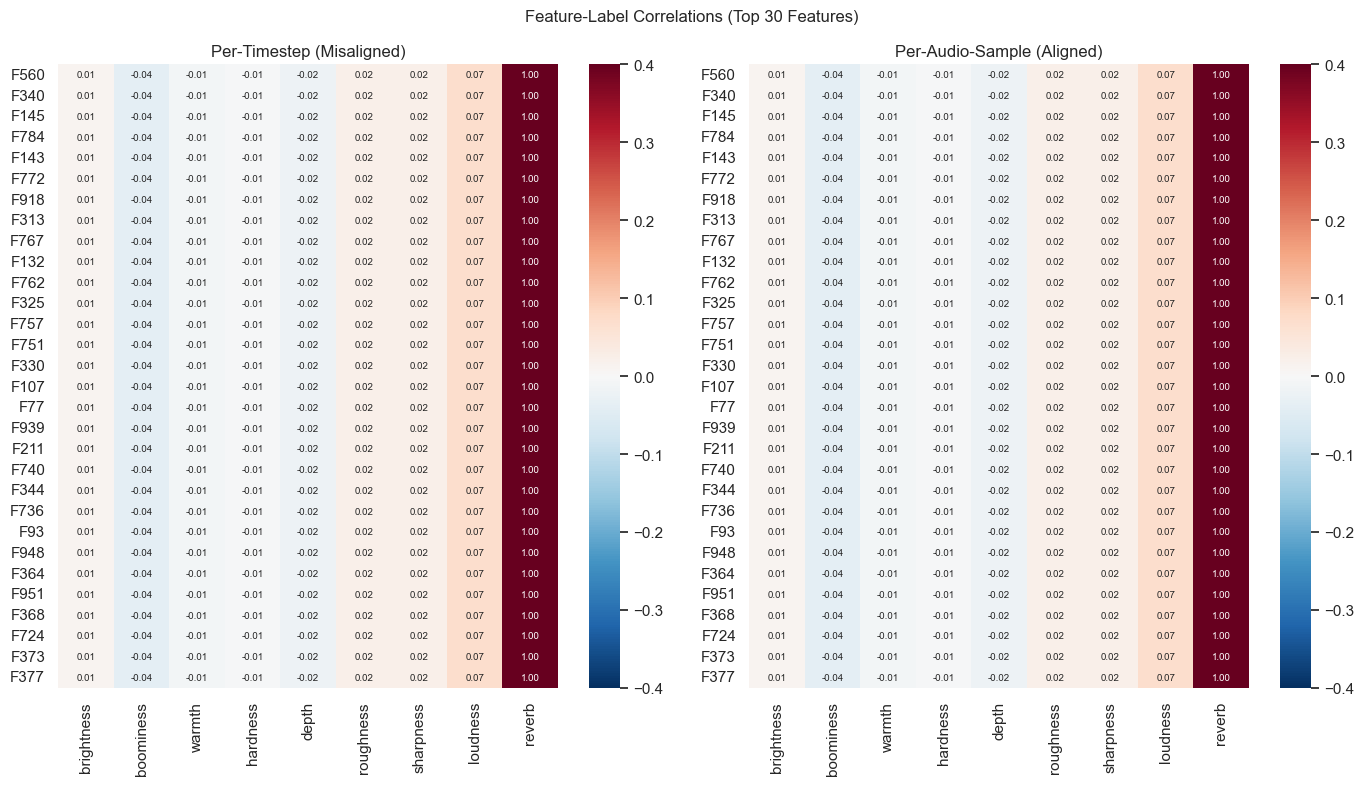

In [10]:
top_feat = np.argsort(np.abs(corr_agg).max(axis=1))[-30:][::-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
for ax, (corr, title) in zip(
    axes,
    [
        (corr_timestep, "Per-Timestep (Misaligned)"),
        (corr_agg, "Per-Audio-Sample (Aligned)"),
    ],
):
    sns.heatmap(
        corr[top_feat],
        xticklabels=config.label_columns,
        yticklabels=[f"F{i}" for i in top_feat],
        cmap="RdBu_r",
        center=0,
        vmin=-0.4,
        vmax=0.4,
        annot=True,
        fmt=".2f",
        ax=ax,
        annot_kws={"size": 7},
    )
    ax.set_title(title)

plt.suptitle("Feature-Label Correlations (Top 30 Features)", fontsize=12)
plt.tight_layout()
plt.savefig("plots/02_correlations.png")
plt.show()

In [11]:
def get_top_activating(h, k=10):
    """Return (d_hidden, k) indices and values of top-k activations per feature."""
    vals, idx = torch.topk(h.T, k=k, dim=1)
    return idx, vals


top_idx, top_vals = get_top_activating(h, k=10)


def show_feature(feat_id):
    """Display top-activating samples for a feature."""
    samples = top_idx[feat_id].numpy()
    acts = top_vals[feat_id].numpy()
    df = metadata.iloc[samples][["id"] + list(config.label_columns)].copy()
    df.insert(0, "activation", acts)
    df.insert(1, "audio_file", samples // config.n_timesteps)
    df.insert(2, "timestep", samples % config.n_timesteps)
    return df


# Example
print("\nFeature 216 (top activating samples):")
print(show_feature(216).head(10).to_string(index=False))


Feature 216 (top activating samples):
 activation  audio_file  timestep     id  brightness  boominess    warmth  hardness     depth  roughness  sharpness   loudness  reverb
  14.877128       10208         0 453206   18.622448  64.772054 58.096603 28.113958 70.179483   0.000000   1.098216 -18.361328       0
  14.064997        7907         7 212218   50.098500  43.031298 57.763587 52.475643 67.862738  50.023839  40.325312  -9.853786       0
  13.860004        6990         0 186290   24.340170  58.460295 61.547711 36.744444 74.853807  30.093049  12.097902 -20.081514       0
  13.776862       10210         0 453213   20.685869  62.409668 56.946344 28.965818 70.182285   0.000000  22.050970 -18.425974       0
  13.598117        8267        11 249253   29.739177  46.406087 65.226751 50.603253 79.084566  32.285611  38.276167 -20.910076       0
  13.578409        1172         0  40604   20.604827  53.862375 61.260318 32.679754 73.853135  27.834598  32.181992 -14.416957       0
  13.533281     

 ## Phase 2C: Steering Capability

In [12]:
W_dec = model.decoder.weight.data.cpu()
dec_norms = W_dec.norm(dim=0)
is_unit_norm = dec_norms.std() < 0.01

print("=" * 60)
print("PHASE 2C: STEERING CAPABILITY")
print("=" * 60)
print(f"\nDecoder norms: {dec_norms.mean():.4f} ± {dec_norms.std():.4f}")
print(f"Unit normalized: {'Yes' if is_unit_norm else 'No'}")

PHASE 2C: STEERING CAPABILITY

Decoder norms: 1.0000 ± 0.0000
Unit normalized: Yes


In [13]:
h_temporal = h.reshape(n_audio, config.n_timesteps, -1)
early = h_temporal[:, :8, :].mean(dim=(0, 1))
late = h_temporal[:, 24:, :].mean(dim=(0, 1))
attack_ratio = early / (late + 1e-8)

attack_features = torch.argsort(attack_ratio, descending=True)[:10]
sustain_features = torch.argsort(attack_ratio)[:10]

print(f"\nAttack features (fire early): {attack_features.tolist()}")
print(f"Sustain features (fire late): {sustain_features.tolist()}")


Attack features (fire early): [221, 279, 245, 790, 116, 62, 456, 916, 833, 123]
Sustain features (fire late): [700, 186, 1, 695, 1018, 368, 1012, 692, 7, 377]


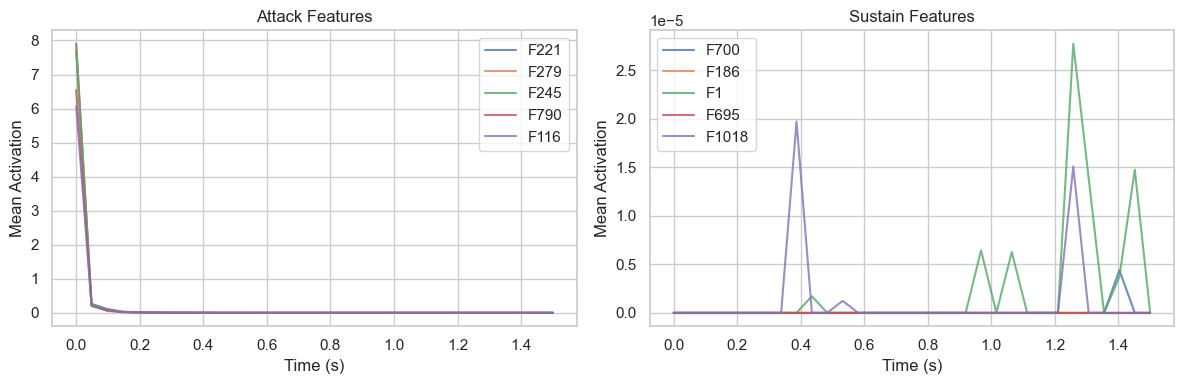

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
time_sec = np.linspace(0, 1.5, config.n_timesteps)
temporal_mean = h_temporal.mean(dim=0)

for ax, feats, title in [
    (axes[0], attack_features[:5], "Attack Features"),
    (axes[1], sustain_features[:5], "Sustain Features"),
]:
    for f in feats:
        ax.plot(time_sec, temporal_mean[:, f].numpy(), label=f"F{f}", alpha=0.8)
    ax.set(xlabel="Time (s)", ylabel="Mean Activation", title=title)
    ax.legend()

plt.tight_layout()
plt.savefig("plots/03_temporal.png")
plt.show()

In [15]:
def build_control_vector(label, corr, W_dec, top_k=20):
    """Build steering direction from top-correlated features."""
    label_idx = config.label_columns.index(label)
    c = corr[:, label_idx]
    top = np.argsort(np.abs(c))[-top_k:]
    weights = torch.tensor(c[top], dtype=torch.float32)
    vec = W_dec[:, top] @ weights
    return vec / vec.norm(), c[top]


control_vecs = {}
print(f"\n{'Label':<12} {'Max |ρ|':>8} {'# |ρ|>0.1':>10}")
print("-" * 35)
for label in config.label_columns:
    cv, top_corrs = build_control_vector(label, corr_agg, W_dec)
    control_vecs[label] = cv
    max_c = np.abs(corr_agg[:, config.label_columns.index(label)]).max()
    n_strong = (np.abs(corr_agg[:, config.label_columns.index(label)]) > 0.1).sum()
    print(f"{label:<12} {max_c:>8.3f} {n_strong:>10}")


Label         Max |ρ|  # |ρ|>0.1
-----------------------------------
brightness      0.494         64
boominess       0.465         77
warmth          0.463         62
hardness        0.465         75
depth           0.510         68
roughness       0.565         73
sharpness       0.493         68
loudness        0.380         55
reverb          1.000        853


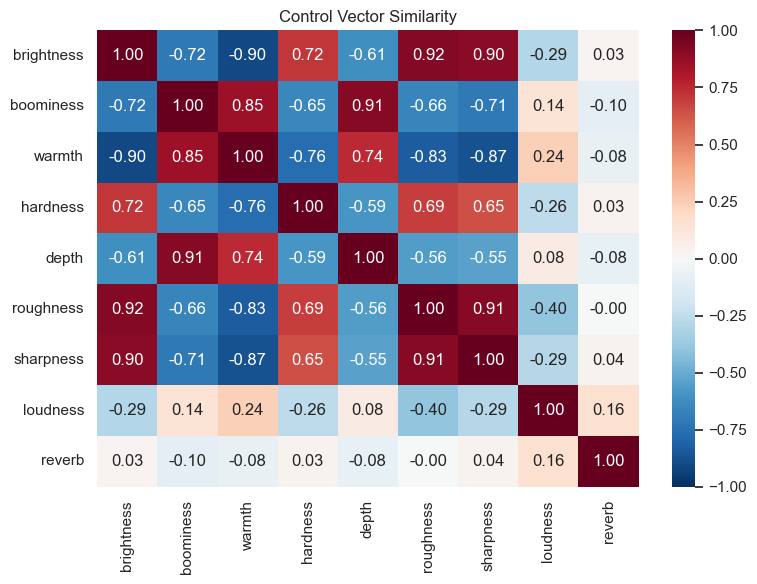

In [16]:
cv_matrix = torch.stack(list(control_vecs.values()))
cv_cos = (cv_matrix @ cv_matrix.T).numpy()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cv_cos,
    xticklabels=config.label_columns,
    yticklabels=config.label_columns,
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    ax=ax,
)
ax.set_title("Control Vector Similarity")
plt.tight_layout()
plt.savefig("plots/04_control_vectors.png")
plt.show()

In [17]:
print("\n" + "=" * 60)
print("STEERING VIABILITY ASSESSMENT")
print("=" * 60)


def assess(label):
    c = corr_agg[:, config.label_columns.index(label)]
    max_abs = np.abs(c).max()
    if max_abs > 0.3:
        return "GOOD"
    elif max_abs > 0.15:
        return "MODERATE"
    else:
        return "WEAK"


print(f"\n{'Label':<12} {'Max |ρ|':>8} {'Viability':>12}")
print("-" * 35)
results = {}
for label in config.label_columns:
    c = corr_agg[:, config.label_columns.index(label)]
    results[label] = assess(label)
    print(f"{label:<12} {np.abs(c).max():>8.3f} {results[label]:>12}")

good = [l for l, v in results.items() if v == "GOOD"]
moderate = [l for l, v in results.items() if v == "MODERATE"]
weak = [l for l, v in results.items() if v == "WEAK"]

print(f"\n✅ Ready for steering: {good + moderate if good + moderate else 'None'}")
print(f"⚠️  Weak signal: {weak if weak else 'None'}")


STEERING VIABILITY ASSESSMENT

Label         Max |ρ|    Viability
-----------------------------------
brightness      0.494         GOOD
boominess       0.465         GOOD
warmth          0.463         GOOD
hardness        0.465         GOOD
depth           0.510         GOOD
roughness       0.565         GOOD
sharpness       0.493         GOOD
loudness        0.380         GOOD
reverb          1.000         GOOD

✅ Ready for steering: ['brightness', 'boominess', 'warmth', 'hardness', 'depth', 'roughness', 'sharpness', 'loudness', 'reverb']
⚠️  Weak signal: None


In [18]:
def inspect_feature(feat_id):
    """Full analysis of a single feature."""
    h_feat = h[:, feat_id]
    active = h_feat > 0

    print(f"\n{'=' * 50}")
    print(f"FEATURE {feat_id}")
    print(f"{'=' * 50}")
    print(f"Usage: {active.sum():,} / {len(h):,} ({active.float().mean():.2%})")
    print(f"Mean activation (when active): {h_feat[active].mean():.3f}")
    print(f"Max activation: {h_feat.max():.3f}")

    print(f"\nTop correlations:")
    for i, label in enumerate(config.label_columns):
        print(f"  {label:<12}: {corr_agg[feat_id, i]:+.3f}")

    print(f"\nTop-5 activating samples:")
    print(show_feature(feat_id).head(5).to_string(index=False))

    print(f"\nTemporal bias (early/late): {attack_ratio[feat_id]:.2f}x")


# Inspect most interesting features
for label in ["brightness", "loudness", "depth"]:
    best = np.argmax(np.abs(corr_agg[:, config.label_columns.index(label)]))
    print(f"\n>>> Best feature for '{label}': F{best}")
    inspect_feature(best)


>>> Best feature for 'brightness': F845

FEATURE 845
Usage: 26,501 / 328,128 (8.08%)
Mean activation (when active): 1.678
Max activation: 9.824

Top correlations:
  brightness  : +0.494
  boominess   : -0.292
  warmth      : -0.411
  hardness    : +0.411
  depth       : -0.256
  roughness   : +0.565
  sharpness   : +0.493
  loudness    : +0.076
  reverb      : +0.057

Top-5 activating samples:
 activation  audio_file  timestep     id  brightness  boominess    warmth  hardness     depth  roughness  sharpness   loudness  reverb
   9.824471         970         0  34466   78.192815  12.424454 23.760721 72.739324 31.729921  68.111571  73.502007 -21.175991       0
   9.255777        5964         0 147723   67.858479  24.489760 30.080601 77.658453 48.679537  67.595285  59.987650 -21.291576       0
   8.526847        6774         0 171922   69.965256  20.837877 35.773765 75.368001 42.415697  77.090665  62.242588 -20.424986       0
   8.216352        7317         1 200183   80.705546  21.96245

In [19]:
summary = pd.DataFrame(
    {
        "feature": range(model.d_hidden),
        "usage": feature_usage.numpy(),
        "usage_pct": (feature_usage / len(dataset) * 100).numpy(),
        "is_dead": dead_mask.numpy(),
        "attack_ratio": attack_ratio.numpy(),
        **{f"corr_{l}": corr_agg[:, i] for i, l in enumerate(config.label_columns)},
    }
)
# summary.to_csv("feature_summary.csv", index=False)
print("\n✅ Saved feature_summary.csv")


✅ Saved feature_summary.csv


In [20]:
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"""
Phase 2A (Evaluation):
  • R² = {explained_var.mean():.3f} (target: >0.90) {"✅" if explained_var.mean() > 0.9 else "❌"}
  • L0 = {l0.mean():.1f} (target: {model.topk}) {"✅" if abs(l0.mean() - model.topk) < 1 else "❌"}
  • Dead features: {dead_mask.sum()}/{model.d_hidden} {"✅" if dead_mask.float().mean() < 0.05 else "❌"}

Phase 2B (Feature Analysis):
  • Correlations improved {(np.abs(corr_agg).max() / np.abs(corr_timestep).max()):.1f}x after aggregation
  • Max |ρ| = {np.abs(corr_agg).max():.3f}
  • Temporal features identified (attack vs sustain)

Phase 2C (Steering):
  • Decoder {"✅ unit normalized" if is_unit_norm else "⚠️ not unit normalized"}
  • Viable labels: {[l for l, v in results.items() if v != "WEAK"]}
  • Recommendation: {"Test steering!" if good else "Consider per-timestep labels"}
""")


SUMMARY

Phase 2A (Evaluation):
  • R² = 0.987 (target: >0.90) ✅
  • L0 = 63.9 (target: 64) ✅
  • Dead features: 3/1024 ✅

Phase 2B (Feature Analysis):
  • Correlations improved 1.0x after aggregation
  • Max |ρ| = 1.000
  • Temporal features identified (attack vs sustain)

Phase 2C (Steering):
  • Decoder ✅ unit normalized
  • Viable labels: ['brightness', 'boominess', 'warmth', 'hardness', 'depth', 'roughness', 'sharpness', 'loudness', 'reverb']
  • Recommendation: Test steering!



 ## Phase 2D: Advanced Visualizations

 - UMAP embedding colored by acoustic properties
 - Feature co-occurrence matrix
 - Temporal activation heatmap

In [21]:
print("=" * 60)
print("PHASE 2D: ADVANCED VISUALIZATIONS")
print("=" * 60)

# Try UMAP, fall back to PCA
try:
    from umap import UMAP

    reducer = UMAP(
        n_components=2, n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=-1
    )
    method_name = "UMAP"
except ImportError:
    print("UMAP not installed, using PCA. Install with: pip install umap-learn")
    reducer = PCA(n_components=2, random_state=42)
    method_name = "PCA"

# Subsample for speed (10k audio samples)
n_subsample = min(10_000, n_audio)
subsample_idx = np.random.choice(n_audio, n_subsample, replace=False)
h_subsample = h_agg[subsample_idx].numpy()
meta_subsample = meta_agg.iloc[subsample_idx]

print(f"Computing {method_name} embedding on {n_subsample:,} samples...")
embedding = reducer.fit_transform(h_subsample)

PHASE 2D: ADVANCED VISUALIZATIONS
Computing UMAP embedding on 10,000 samples...


/Users/omarhammami/hambaLab/Output/drums_SAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


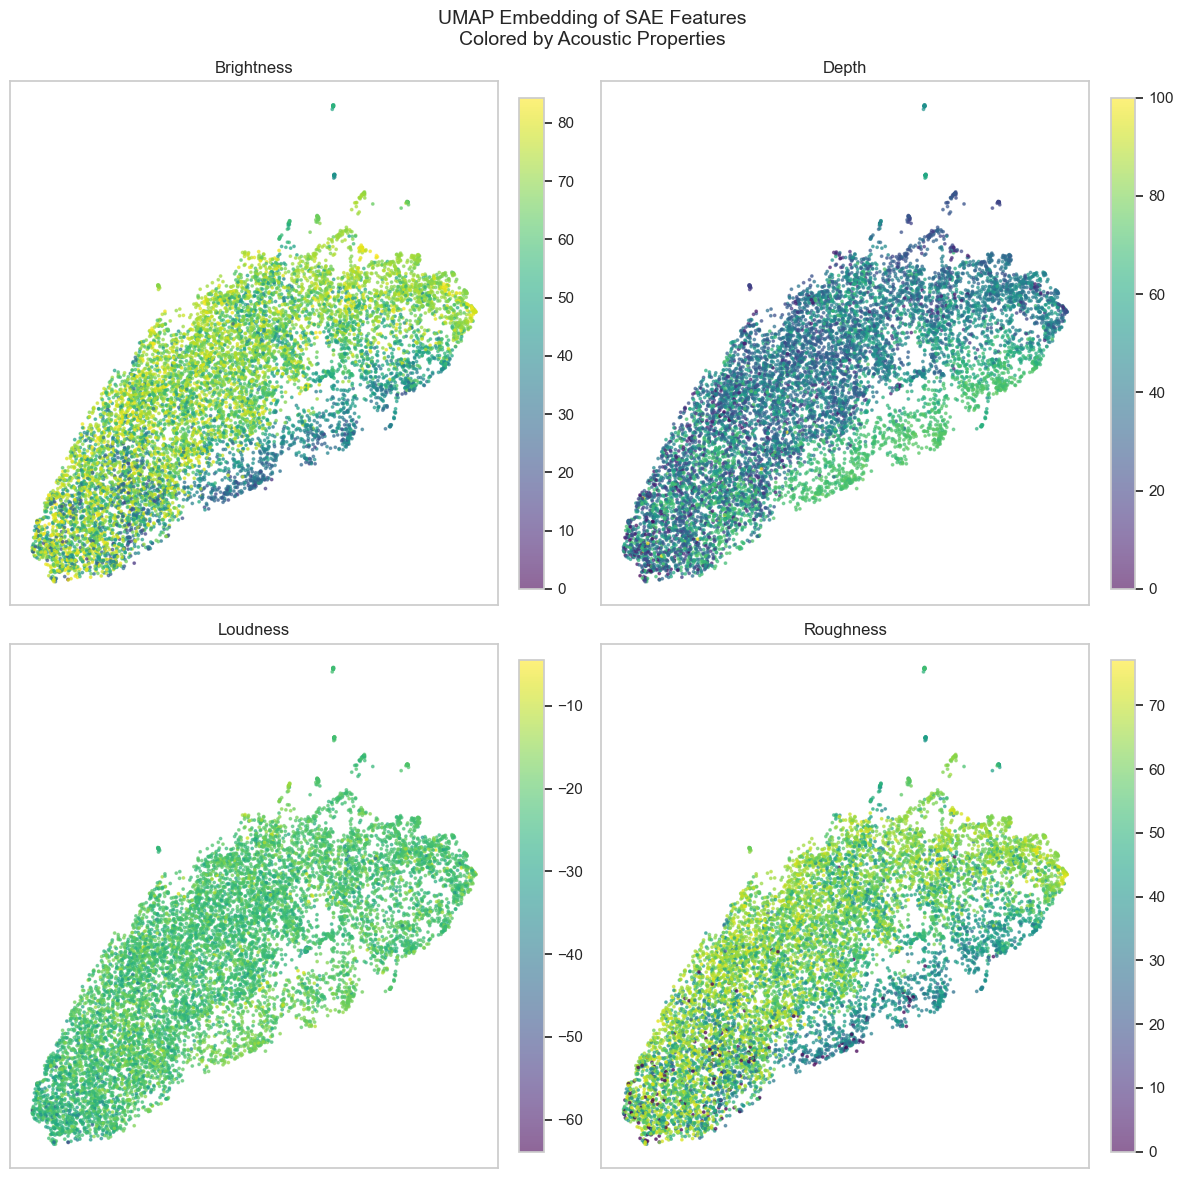

In [22]:
key_labels = ["brightness", "depth", "loudness", "roughness"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, label in zip(axes, key_labels):
    values = meta_subsample[label].values

    # Handle potential NaN/inf
    valid = np.isfinite(values)

    scatter = ax.scatter(
        embedding[valid, 0],
        embedding[valid, 1],
        c=values[valid],
        cmap="viridis",
        s=3,
        alpha=0.6,
    )
    ax.set_title(label.capitalize(), fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(
    f"{method_name} Embedding of SAE Features\nColored by Acoustic Properties",
    fontsize=14,
)
plt.tight_layout()
plt.savefig("plots/05_umap_by_properties.png", dpi=150)
plt.show()

In [23]:
print("\nComputing feature co-occurrence matrix...")

# Binary activation matrix (which features fire together)
active = (h_agg > 0).float()  # (n_audio, 1024)
cooccur = (active.T @ active).numpy()  # (1024, 1024)
cooccur_normalized = cooccur / n_audio  # P(both fire)

# Select top 100 most-used features for visibility
top_100_features = torch.argsort(feature_usage, descending=True)[:100].numpy()
cooccur_subset = cooccur_normalized[np.ix_(top_100_features, top_100_features)]


Computing feature co-occurrence matrix...


Generating co-occurrence clustermap...


/Users/omarhammami/hambaLab/Output/drums_SAE/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/omarhammami/hambaLab/Output/drums_SAE/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


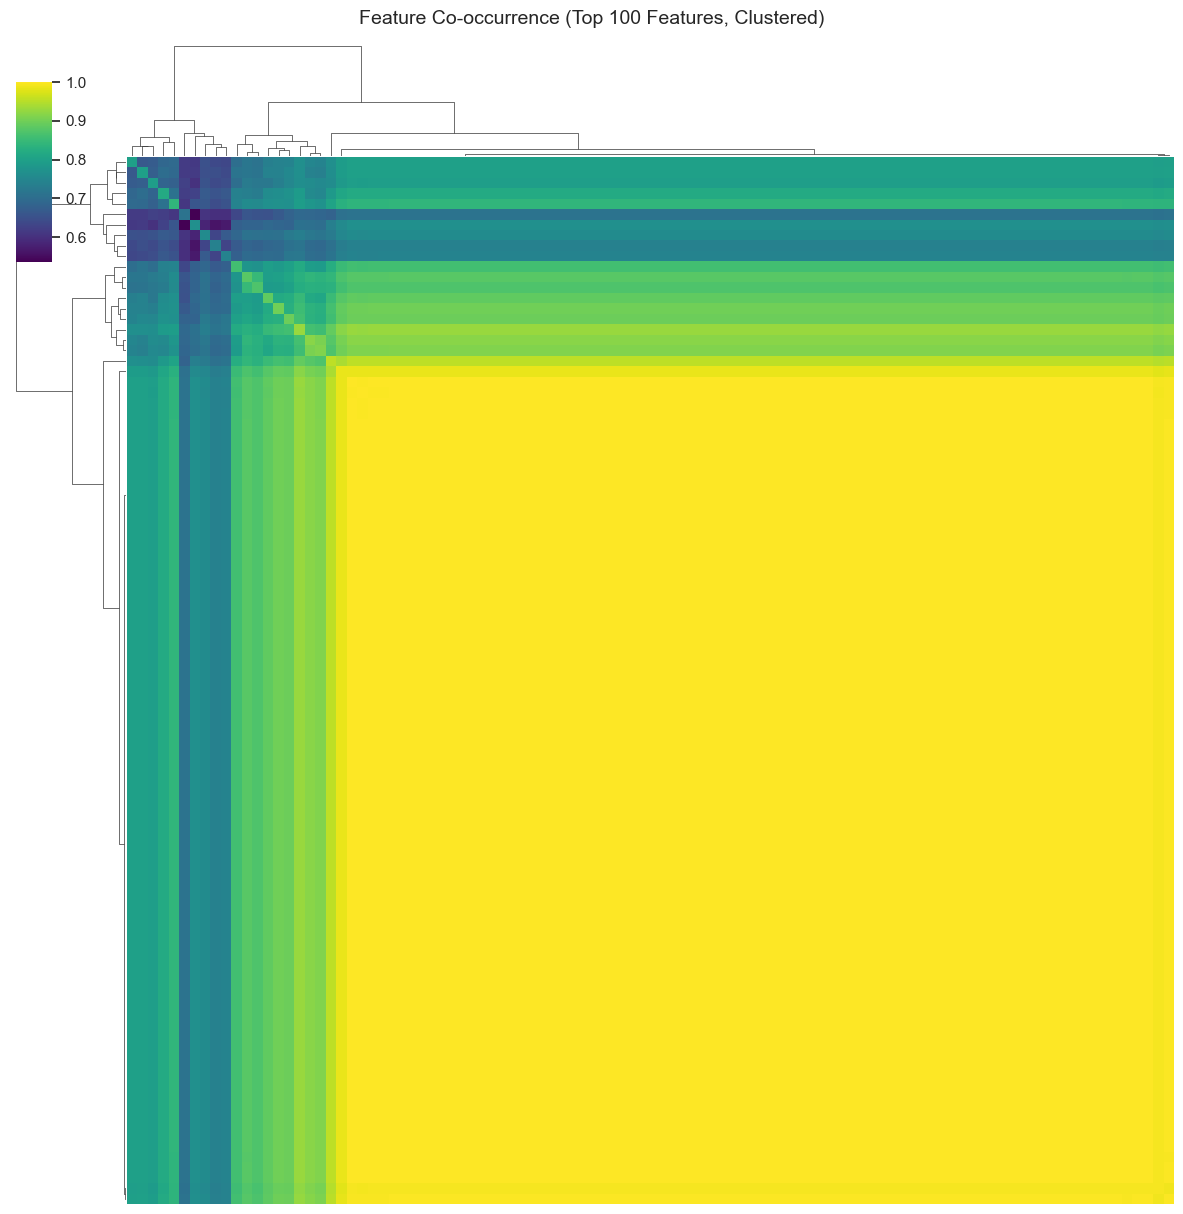


Co-occurrence statistics:
  Mean P(i,j both fire): 0.0140
  Max P(i,j both fire): 1.0000

Top 5 co-occurring feature pairs:
  F453 & F657: P=1.000
  F891 & F910: P=1.000
  F793 & F854: P=1.000
  F504 & F796: P=1.000
  F891 & F904: P=1.000


In [24]:
print("Generating co-occurrence clustermap...")

g = sns.clustermap(
    cooccur_subset,
    cmap="viridis",
    figsize=(12, 12),
    xticklabels=False,
    yticklabels=False,
    dendrogram_ratio=0.1,
    cbar_pos=(0.02, 0.8, 0.03, 0.15),
)
g.fig.suptitle(
    "Feature Co-occurrence (Top 100 Features, Clustered)", fontsize=14, y=1.01
)
plt.savefig("plots/06_cooccurrence_clustermap.png", dpi=150, bbox_inches="tight")
plt.show()

# Co-occurrence stats
np.fill_diagonal(cooccur_normalized, 0)  # Exclude self-cooccurrence
print(f"\nCo-occurrence statistics:")
print(f"  Mean P(i,j both fire): {cooccur_normalized.mean():.4f}")
print(f"  Max P(i,j both fire): {cooccur_normalized.max():.4f}")

# Top co-occurring pairs
upper_tri = np.triu(cooccur_normalized, k=1)
top_pairs_flat = np.argsort(upper_tri.flatten())[-10:][::-1]
print(f"\nTop 5 co-occurring feature pairs:")
for flat_idx in top_pairs_flat[:5]:
    i, j = flat_idx // 1024, flat_idx % 1024
    print(f"  F{i} & F{j}: P={cooccur_normalized[i, j]:.3f}")


Generating temporal activation heatmap...


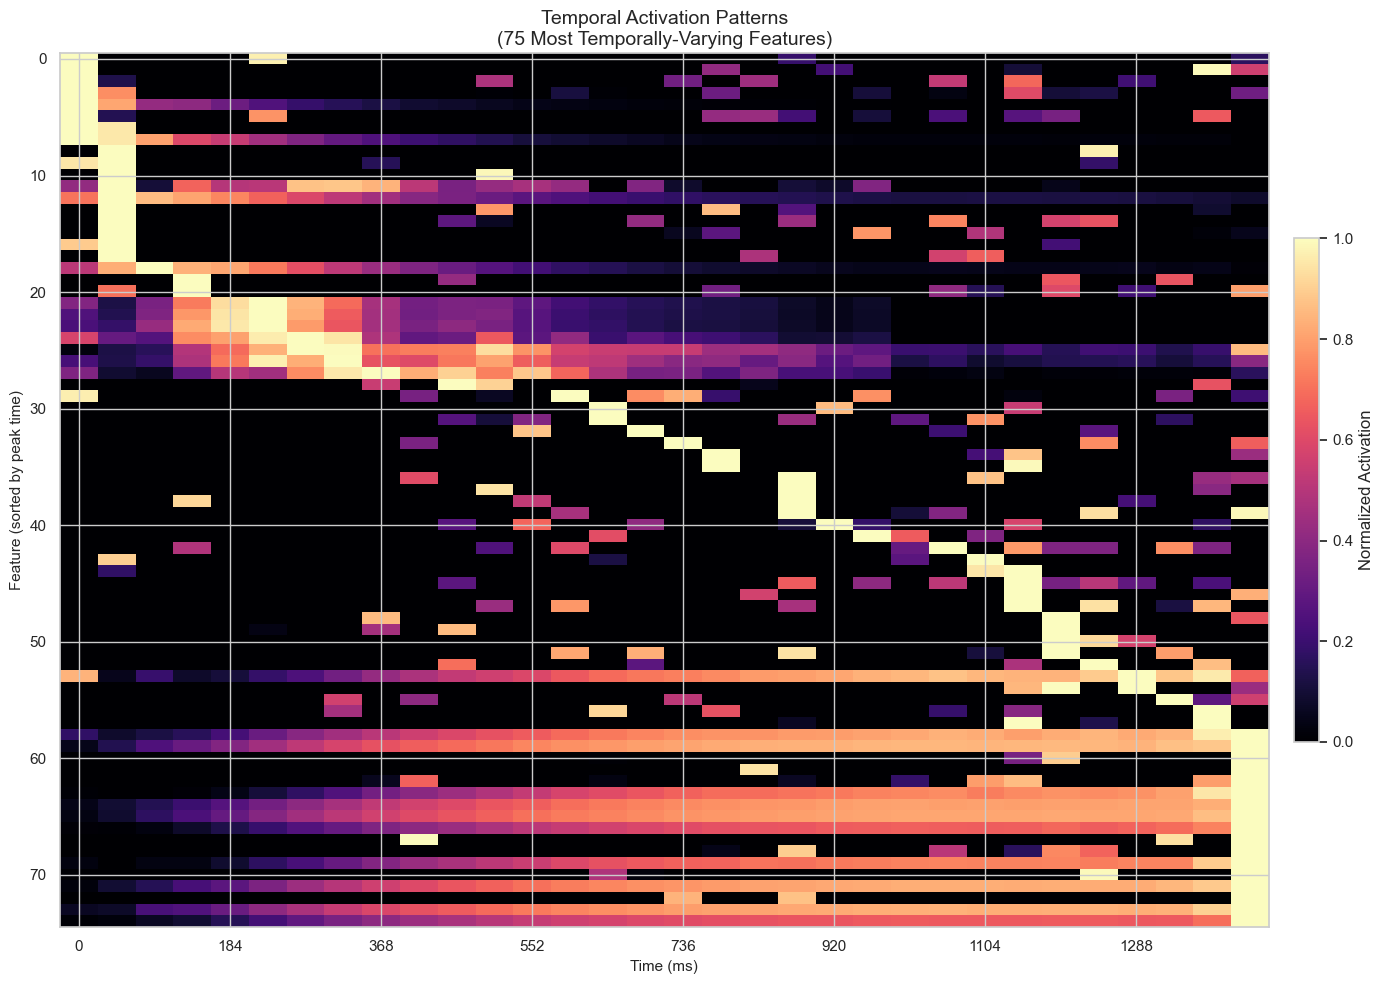

In [25]:
print("\nGenerating temporal activation heatmap...")

# Mean activation per feature per timestep: (32, 1024)
temporal_matrix = h_temporal.mean(dim=0).numpy()  # Average across all audio samples

# Normalize each feature to [0, 1] for visualization
temporal_normed = temporal_matrix / (temporal_matrix.max(axis=0, keepdims=True) + 1e-10)

# Select features with high temporal variance (most interesting)
temporal_variance = temporal_normed.var(axis=0)
top_temporal_features = np.argsort(temporal_variance)[
    -75:
]  # Top 75 most temporally varying

# Sort by peak time for nicer visualization
peak_times = temporal_normed[:, top_temporal_features].argmax(axis=0)
sorted_order = np.argsort(peak_times)
features_sorted = top_temporal_features[sorted_order]

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(
    temporal_normed[:, features_sorted].T,
    aspect="auto",
    cmap="magma",
    interpolation="nearest",
)

# Time axis in ms
time_labels = [f"{int(t * 46)}" for t in range(0, config.n_timesteps, 4)]
ax.set_xticks(range(0, config.n_timesteps, 4))
ax.set_xticklabels(time_labels)
ax.set_xlabel("Time (ms)", fontsize=11)
ax.set_ylabel("Feature (sorted by peak time)", fontsize=11)
ax.set_title(
    "Temporal Activation Patterns\n(75 Most Temporally-Varying Features)", fontsize=14
)

plt.colorbar(im, ax=ax, label="Normalized Activation", fraction=0.02, pad=0.02)
plt.tight_layout()
plt.savefig("plots/07_temporal_heatmap.png", dpi=150)
plt.show()

In [26]:
early_features = features_sorted[:15]  # Fire early
late_features = features_sorted[-15:]  # Fire late

print(f"\nTemporal structure:")
print(f"  Early-firing features (attack): {early_features.tolist()}")
print(f"  Late-firing features (sustain): {late_features.tolist()}")


Temporal structure:
  Early-firing features (attack): [972, 928, 459, 207, 737, 597, 582, 405, 714, 269, 410, 927, 796, 989, 109]
  Late-firing features (sustain): [338, 1012, 391, 282, 628, 977, 756, 552, 168, 1011, 880, 793, 873, 159, 644]



Visualizing decoder directions with PCA...


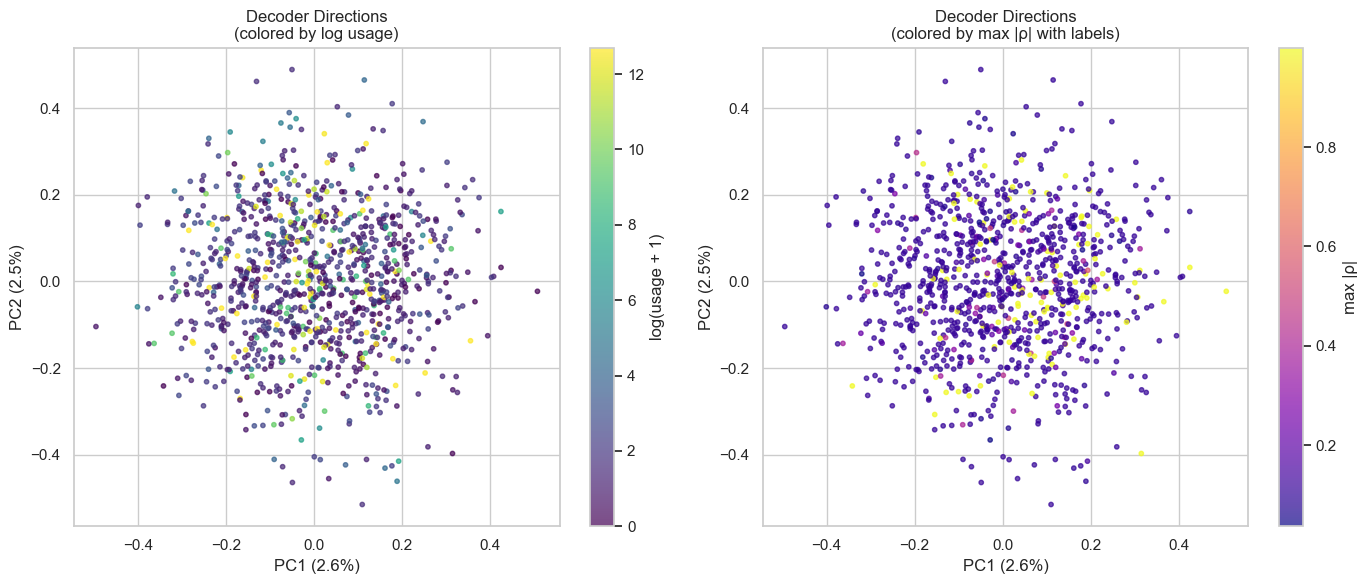

In [27]:
print("\nVisualizing decoder directions with PCA...")

# Project 1024 decoder columns (each is 64-dim) to 2D
decoder_pca = PCA(n_components=2)
decoder_2d = decoder_pca.fit_transform(W_dec.T.numpy())  # (1024, 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color by feature usage
ax = axes[0]
usage_colors = np.log1p(feature_usage.numpy())  # Log scale for visibility
scatter = ax.scatter(
    decoder_2d[:, 0], decoder_2d[:, 1], c=usage_colors, cmap="viridis", s=10, alpha=0.7
)
ax.set_xlabel(f"PC1 ({decoder_pca.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({decoder_pca.explained_variance_ratio_[1]:.1%})")
ax.set_title("Decoder Directions\n(colored by log usage)")
plt.colorbar(scatter, ax=ax, label="log(usage + 1)")

# Color by best correlation
ax = axes[1]
best_corr = np.abs(corr_agg).max(axis=1)  # Max |ρ| for each feature
scatter = ax.scatter(
    decoder_2d[:, 0], decoder_2d[:, 1], c=best_corr, cmap="plasma", s=10, alpha=0.7
)
ax.set_xlabel(f"PC1 ({decoder_pca.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({decoder_pca.explained_variance_ratio_[1]:.1%})")
ax.set_title("Decoder Directions\n(colored by max |ρ| with labels)")
plt.colorbar(scatter, ax=ax, label="max |ρ|")

plt.tight_layout()
plt.savefig("plots/08_decoder_pca.png", dpi=150)
plt.show()


Generating feature-label correlation clustermap...
Features with |ρ| > 0.15: 83


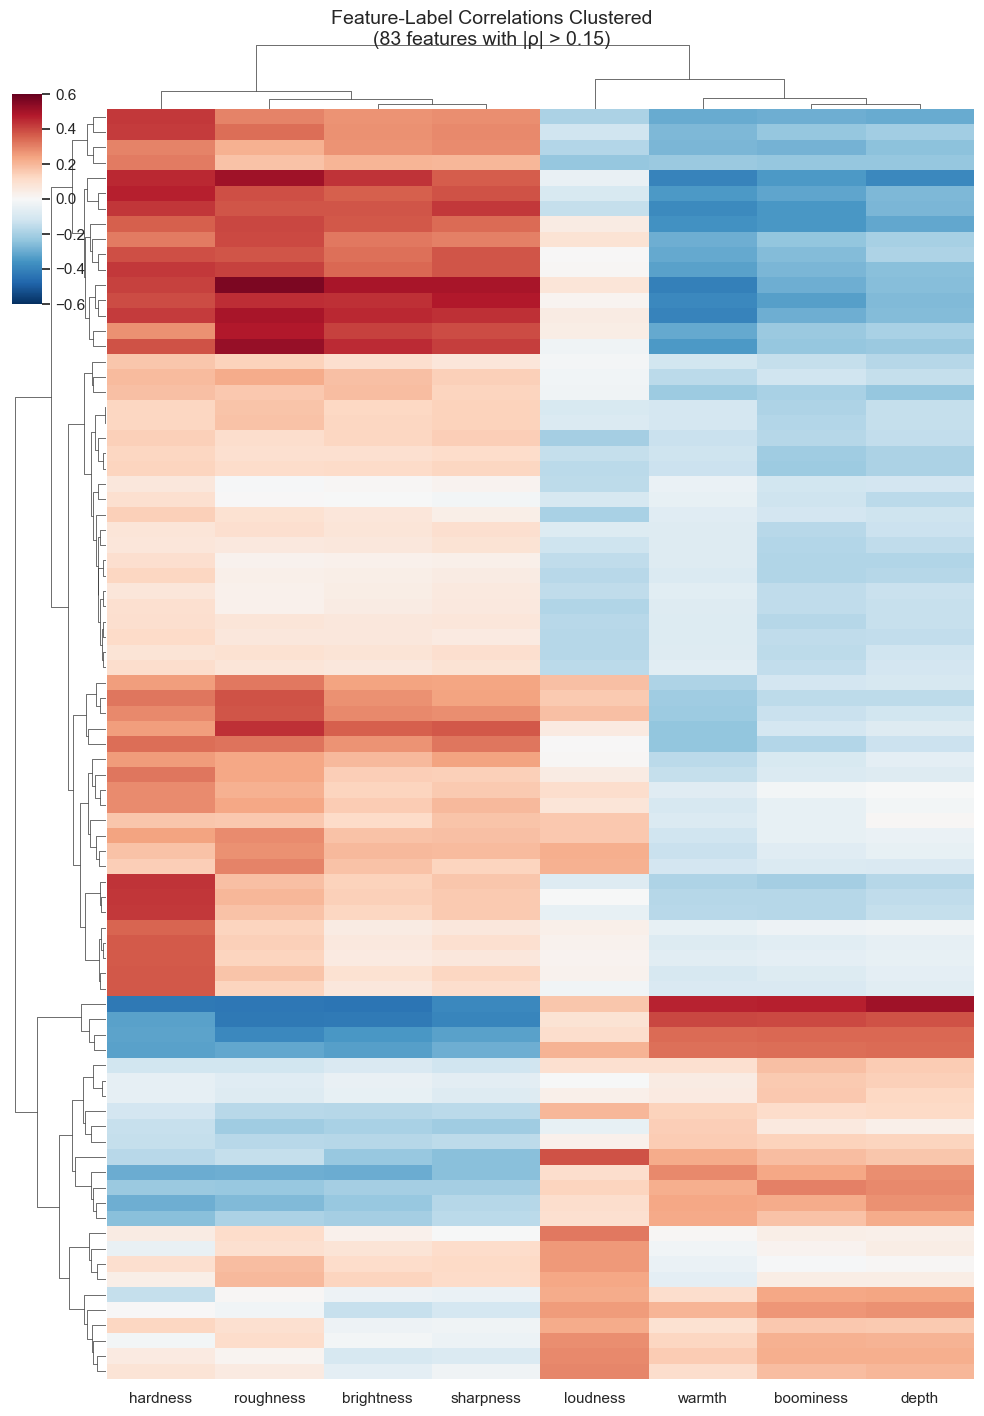

In [28]:
print("\nGenerating feature-label correlation clustermap...")

# Cluster features by their correlation profiles
# Exclude reverb (binary, meaningless correlations)
labels_no_reverb = [l for l in config.label_columns if l != "reverb"]
corr_no_reverb = corr_agg[:, [config.label_columns.index(l) for l in labels_no_reverb]]

# Select features with strong correlations
strong_corr_mask = np.abs(corr_no_reverb).max(axis=1) > 0.15
strong_features = np.where(strong_corr_mask)[0]
print(f"Features with |ρ| > 0.15: {len(strong_features)}")

g = sns.clustermap(
    corr_no_reverb[strong_features],
    cmap="RdBu_r",
    center=0,
    vmin=-0.6,
    vmax=0.6,
    figsize=(10, 14),
    xticklabels=labels_no_reverb,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.02, 0.8, 0.03, 0.15),
)
g.fig.suptitle(
    f"Feature-Label Correlations Clustered\n({len(strong_features)} features with |ρ| > 0.15)",
    fontsize=14,
    y=1.01,
)
plt.savefig("plots/09_correlation_clustermap.png", dpi=150, bbox_inches="tight")
plt.show()

In [29]:
print("\n" + "=" * 60)
print("VISUALIZATION SUMMARY")
print("=" * 60)
print(f"""
Generated plots:
 📊 plots/01_phase2a_metrics.png     - Reconstruction & sparsity metrics
 📊 plots/02_correlations.png        - Before/after aggregation comparison
 📊 plots/03_temporal.png            - Attack vs sustain feature profiles
 📊 plots/04_control_vectors.png     - Control vector similarity matrix
 📊 plots/05_umap_by_properties.png  - {method_name} embedding by acoustic properties
 📊 plots/06_cooccurrence_clustermap.png - Feature co-activation structure
 📊 plots/07_temporal_heatmap.png    - When features fire (32 timesteps)
 📊 plots/08_decoder_pca.png         - Decoder direction geometry
 📊 plots/09_correlation_clustermap.png - Features clustered by correlations

Key insights:
 • {method_name} shows {"smooth gradients" if method_name == "UMAP" else "structure"} for acoustic properties
 • Co-occurrence reveals feature "modules" that fire together
 • Temporal heatmap shows clear attack→sustain progression
 • Decoder PCA shows feature directions are well-spread (good for steering)
""")


VISUALIZATION SUMMARY

Generated plots:
 📊 plots/01_phase2a_metrics.png     - Reconstruction & sparsity metrics
 📊 plots/02_correlations.png        - Before/after aggregation comparison
 📊 plots/03_temporal.png            - Attack vs sustain feature profiles
 📊 plots/04_control_vectors.png     - Control vector similarity matrix
 📊 plots/05_umap_by_properties.png  - UMAP embedding by acoustic properties
 📊 plots/06_cooccurrence_clustermap.png - Feature co-activation structure
 📊 plots/07_temporal_heatmap.png    - When features fire (32 timesteps)
 📊 plots/08_decoder_pca.png         - Decoder direction geometry
 📊 plots/09_correlation_clustermap.png - Features clustered by correlations

Key insights:
 • UMAP shows smooth gradients for acoustic properties
 • Co-occurrence reveals feature "modules" that fire together
 • Temporal heatmap shows clear attack→sustain progression
 • Decoder PCA shows feature directions are well-spread (good for steering)

